In [118]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
import matplotlib.pyplot as plt
from math import sqrt


In [188]:
df_train = pd.read_csv('Google_Stock_Price_Train.csv', thousands=',')
df_train = df_train.iloc[:,1:]
df_train = np.array(df_train)


In [189]:
df_test = pd.read_csv('Google_Stock_Price_Test.csv', thousands=',')
df_test = df_test.iloc[:,1:]
df_test = np.array(df_train)

In [7]:
def time_series_generator(dataset, steps):
    list_X, list_y = list(), list()
    for i in range(len(dataset) - steps - 1):
        X = dataset[i : i + steps]
        y = dataset[i + steps]
        list_X.append(X)
        list_y.append(y)
    return np.array(list_X), np.array(list_y)

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
df_train = scaler.fit_transform(df_train)


In [190]:
df_test = scaler.transform(df_test)

In [9]:
val_ratio = 0.2
val_size = int(val_ratio * df_train.shape[0])
train_set = df_train[0:-val_size]
val_set = df_train[-val_size:]

In [191]:
steps = 5
X_train, y_train = time_series_generator(train_set, steps)
X_val, y_val = time_series_generator(val_set, steps)
X_test, y_test = time_series_generator(df_test, steps)

In [12]:
# X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 5)
# X_val =X_val.reshape(X_val.shape[0],X_val.shape[1] , 5)


In [34]:
def build_model(neuron,n_steps, n_features):
    model = Sequential()
    model.add(LSTM(neuron, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(neuron, activation='relu'))
    model.add(Dense(n_features))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
    return model
    


In [199]:
def calculate_RMSE(y_pred, y_test):
    s = 0
    for row in range(y_test.shape[0]):
        for col in range(y_test.shape[1]):
            s += (y_test[row,col] - y_pred[row,col]) ** 2
    score = sqrt(s/y_test.shape[0] * y_test.shape[1])
    return score

In [170]:
def build_model2(n_layers,n_steps, n_features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    for i in range(n_layers-1):
        model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(LSTM(neuron, activation='relu'))
    model.add(Dense(n_features))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

# 1. Experiment 1

In [54]:
repeat = 4
scores = []
n_steps = [3,4,5,6]
n_features = 5
for i in range(repeat):
    for n_step in n_steps:
        model = build_model(50,n_step,n_features)
        X_train, y_train = time_series_generator(train_set, n_step)
        X_val, y_val = time_series_generator(val_set, n_step)

        model.fit(X_train, y_train,epochs=25, batch_size=1, verbose = 0 )
        y_pred = model.predict(X_val)
        scores.append(calculate_RMSE(y_pred, y_val))

In [49]:
scores

[0.1396289667877321,
 0.10765033993445035,
 0.11122643707661684,
 0.12028541678624134]

In [57]:
scores = np.array(scores).reshape(len(n_steps),repeat)
scores

array([[0.12442871, 0.1687274 , 0.12101473, 0.11684393],
       [0.11542517, 0.1339387 , 0.15217013, 0.13469609],
       [0.11478486, 0.10860589, 0.16268319, 0.10032878],
       [0.11986193, 0.17061645, 0.11248301, 0.22433718]])

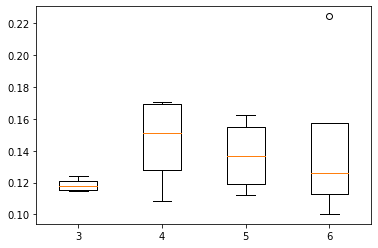

In [97]:
plt.boxplot(scores, labels = [3,4,5,6])
plt.show()

# 2. Experiment 2

In [152]:
steps = 5
X_train, y_train = time_series_generator(train_set, steps)
X_val, y_val = time_series_generator(val_set, steps)

In [68]:
neurons = [50,60,70,80,90]
repeat = 4
n_features = 5
n_steps = 5
scores_neurons = []
for i in range(repeat):
    for neuron in neurons:
        model = build_model(neuron, n_steps,n_features)
        model.fit(X_train, y_train, epochs=25, batch_size=1, verbose = 0)
        y_pred = model.predict(X_val)
        scores_neurons.append(calculate_RMSE(y_pred, y_val))

In [75]:
scores_neurons = np.array(scores_neurons).reshape(repeat, len(neurons))
scores_neurons

array([[0.12972105, 0.18086255, 0.11481741, 0.11075482, 0.10617817],
       [0.15754874, 0.17230763, 0.10535249, 0.12447586, 0.21163433],
       [0.132592  , 0.11149595, 0.10982555, 0.10696076, 0.11179274],
       [0.15169685, 0.13593095, 0.16522887, 0.14157358, 0.11632592]])

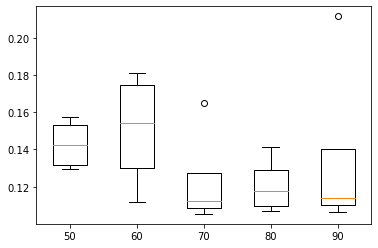

In [94]:
plt.boxplot(scores_neurons, labels=neurons)
plt.show()

In [172]:
n_layers = [1,2,3,4]
steps = 5
repeat = 4
n_features = 5
scores_layers = []

for i in range(4):
    for n_layer in n_layers:
        model = build_model2(n_layer, 5, 5)
        model.fit(X_train, y_train, epochs=25, batch_size=1, verbose = 0)
        y_pred = model.predict(X_val)
        scores_layers.append(calculate_RMSE(y_pred, y_val))

In [176]:
scores_layers = np.array(scores_layers).reshape(repeat, len(n_layers))
scores_layers

array([[0.10408805, 0.12912509, 0.17661613, 0.19966337],
       [0.13159796, 0.1341633 , 0.12342974, 0.1653874 ],
       [0.13291588, 0.15691134, 0.12980797, 0.14551058],
       [0.14146475, 0.14298885, 0.21269562, 0.12290432]])

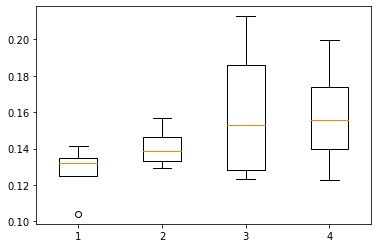

In [178]:
plt.boxplot(scores_layers, labels=n_layers)
plt.show()

# The best model

In [192]:
steps = 3
X_train, y_train = time_series_generator(train_set, steps)
X_val, y_val = time_series_generator(val_set, steps)
X_test, y_test = time_series_generator(df_test, steps)

In [180]:
def build_best_model():
    model = Sequential()
    model.add(LSTM(70, activation='relu', return_sequences=True, input_shape=(3, 5)))
    model.add(LSTM(70, activation='relu',))

    model.add(Dense(5))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

In [181]:
best_model = build_best_model()

In [183]:
best_model.fit(X_train, y_train, epochs=25, batch_size=1, verbose = 2)

Epoch 1/25
1003/1003 - 3s - loss: 0.0409 - mean_squared_error: 0.0049
Epoch 2/25
1003/1003 - 3s - loss: 0.0268 - mean_squared_error: 0.0023
Epoch 3/25
1003/1003 - 3s - loss: 0.0249 - mean_squared_error: 0.0021
Epoch 4/25
1003/1003 - 3s - loss: 0.0247 - mean_squared_error: 0.0021
Epoch 5/25
1003/1003 - 3s - loss: 0.0239 - mean_squared_error: 0.0020
Epoch 6/25
1003/1003 - 3s - loss: 0.0235 - mean_squared_error: 0.0020
Epoch 7/25
1003/1003 - 4s - loss: 0.0228 - mean_squared_error: 0.0020
Epoch 8/25
1003/1003 - 6s - loss: 0.0222 - mean_squared_error: 0.0019
Epoch 9/25
1003/1003 - 3s - loss: 0.0222 - mean_squared_error: 0.0019
Epoch 10/25
1003/1003 - 3s - loss: 0.0218 - mean_squared_error: 0.0018
Epoch 11/25
1003/1003 - 3s - loss: 0.0205 - mean_squared_error: 0.0018
Epoch 12/25
1003/1003 - 3s - loss: 0.0202 - mean_squared_error: 0.0018
Epoch 13/25
1003/1003 - 3s - loss: 0.0199 - mean_squared_error: 0.0017
Epoch 14/25
1003/1003 - 4s - loss: 0.0195 - mean_squared_error: 0.0017
Epoch 15/25
100

In [208]:
y_pred = best_model.predict(X_val)
print('RMSE val', calculate_RMSE(y_pred, y_val))

RMSE val 0.1114151560651446


In [209]:
y_pred = best_model.predict(X_test)
print('RMSE test',calculate_RMSE(y_pred, y_test))

RMSE test 0.18037577088085993
